# How to get Environmental, Social, and Governance data from Refinitiv Data Platform APIs with jupyter/scipy-notebook Docker image.

The [jupyter/scipy-notebook](https://jupyter-docker-stacks.readthedocs.io/en/latest/using/selecting.html#jupyter-scipy-notebook) image provides ready-to-use Jupyter Notebook/JupyterLab application with the [conda](https://github.com/conda/conda)/[mamba](https://github.com/mamba-org/mamba) , [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/) and popular packages from the scientific Python ecosystem ([Pandas](https://pandas.pydata.org/), [Matplotlib](https://matplotlib.org/), [Seaborn](https://seaborn.pydata.org/), [Requests](https://docs.python-requests.org/en/master/), etc.) for developers.

Developers can start the Jupyter server and access the notebook with the following Docker command:

```
docker run -p 8888:8888 --name notebook -v <project /python/notebook/ directory>:/home/jovyan/work -e JUPYTER_ENABLE_LAB=yes --env-file .env jupyter/scipy-notebook:70178b8e48d7
```
The above command set the following container's options:
- ```-p 8888:8888```: Exposes the server on host port 8888
- ```-v <your working directory>:/home/jovyan/work```: Mounts the working directory on the host as /home/jovyan/work folder in the container to save the files between your host machine and a container.
- ```-e JUPYTER_ENABLE_LAB=yes```: Run JupyterLab instead of the default classic Jupyter Notebook.
- ```--name notebook```: Define a container name as *notebook*

*Note*:
- Docker destroys the container after the notebook server exit, so you always need the ```-v``` option.
- The default notebook username of a container is always **jovyan** (but you can change it to something else).

## <a id="whatis_rdp"></a>What is Refinitiv Data Platform (RDP) APIs?

The [Refinitiv Data Platform (RDP) APIs](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) provide various Refinitiv data and content for developers via easy-to-use Web-based API.

RDP APIs give developers seamless and holistic access to all of the Refinitiv content such as Historical Pricing, Environmental Social and Governance (ESG), News, Research, etc and commingled with their content, enriching, integrating, and distributing the data through a single interface, delivered wherever they need it.  The RDP APIs delivery mechanisms are the following:
* Request - Response: RESTful web service (HTTP GET, POST, PUT or DELETE) 
* Alert: delivery is a mechanism to receive asynchronous updates (alerts) to a subscription. 
* Bulks:  deliver substantial payloads, like the end-of-day pricing data for the whole venue. 
* Streaming: deliver real-time delivery of messages.

This example project is focusing on the Request-Response: RESTful web service delivery method only.  

For more detail regarding Refinitiv Data Platform, please see the following APIs resources: 
- [Quick Start](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/quick-start) page.
- [Tutorials](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials) page.
- [RDP APIs: Introduction to the Request-Response API](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials#introduction-to-the-request-response-api) page.
- [RDP APIs: Authorization - All about tokens](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials#authorization-all-about-tokens) page.

## Importing Libraries

The first step is importing all required libraries including the python-dotenv, requests, Pandas, etc. The *jupyter/scipy-notebook* image has all the required libraries for you.

In [1]:
import os
import requests
import pandas as pd
import numpy as np

Next, the notebook application uses ```os.getenv``` statement to get RDP APIs Auth service endpoint and user's RDP credentials configurations from find ```.env``` which you have passed to a container with ```--env-file .env``` option.

In [2]:
# Get RDP Token service information from Environment Variables
base_URL = os.getenv('RDP_BASE_URL')
auth_endpoint = base_URL + os.getenv('RDP_AUTH_URL') 

# Get RDP Credentials information from Environment Variables
username = os.getenv('RDP_USER')
password = os.getenv('RDP_PASSWORD')
app_key = os.getenv('RDP_APP_KEY')

Refinitiv Data Platform entitlement check is based on OAuth 2.0 specification. The first step of an application workflow is to get a token from RDP Auth Service, which will allow access to the protected resource, i.e. data REST APIs. 

We create the RDP Auth Service request message with additional variables in the next step.

In [3]:
# RDP Auth Services request message variables

client_secret = ''
scope = 'trapi'
auth_obj = None

# -- Init and Authenticate Session
auth_request_msg = {
    'username': username ,
    'password': password ,
    'grant_type': "password",
    'scope': scope,
    'takeExclusiveSignOnControl': "true"
}

Now notebook is ready to send the HTTP request message with the *requests* library. 

It keeps the response JSON message which contains the RDP Access Token information in the *auth_obj* variable.

In [4]:
# Authentication with RDP Auth Service
try:
    response = requests.post(auth_endpoint, headers = {'Accept':'application/json'}, data = auth_request_msg, auth = (app_key, client_secret))
except Exception as exp:
    print('Caught exception: %s' % str(exp))

if response.status_code == 200:  # HTTP Status 'OK'
    print('Authentication success')
    auth_obj = response.json() 
else:
    print('RDP authentication result failure: %s %s' % (response.status_code, response.reason))
    print('Text: %s' % (response.text))

Authentication success


After the application received the Access Token (an authorization token) from RDP Auth Service, all subsequent REST API calls will use this token to get the data. The application needs to input Access Token via *Authorization* HTTP request message header as shown below. 
- Header: 
    * Authorization = ```Bearer <RDP Access Token>```

Please notice *the space* between the ```Bearer``` and ```RDP Access Token``` values.

The next step is requesting ESG (Environmental, Social, and Governance) data from RDP. We use the ESG scores-full API endpoint which provides full coverage of Refinitiv's proprietary ESG Scores with full history for consumers as an example API.

We get the RDP ESG Service API endpoint from a ```.env``` file.

In [5]:
# Get RDP Token service information from Environment Variables
esg_url = base_URL + os.getenv('RDP_ESG_URL') 

In [6]:
# ESG Score Full request messages variables

universe = 'TSLA.O'
payload = {'universe': universe}
esg_object = None

In [7]:
# Request data for ESG Score Full Service
try:
    response = requests.get(esg_url, headers={'Authorization': 'Bearer {}'.format(auth_obj['access_token'])}, params = payload)
except Exception as exp:
    print('Caught exception: %s' % str(exp))

if response.status_code == 200:  # HTTP Status 'OK'
    print('Receive ESG Data from RDP APIs success')
    #print(response.json())
    esg_object=response.json()
else:
    print('RDP APIs: ESG data request failure: %s %s' % (response.status_code, response.reason))
    print('Text: %s' % (response.text))

Receive ESG Data from RDP APIs success


Once we receive ESG Data from RDP, we can convert the data from the JSON object to a Pandas Dataframe by the following steps:
1. Gets the data and column name from JSON object and then re-constructs it as a new map object. 
2. Converts the JSON's data field to the numpy array.
3. Create a new Pandas Dataframe from the numpy data array and headers map.

In [8]:
headers=esg_object['headers']
#Get column headers/titles using lambda
titles=map(lambda header:header['title'], headers)
        
dataArray=np.array(esg_object['data'])
df=pd.DataFrame(data=dataArray,columns=titles)

In [9]:
df.head()

,Instrument,Period End Date,ESG Score,ESG Combined Score,ESG Controversies Score,Social Pillar Score,Governance Pillar Score,Environment Pillar Score,Resource Use Score,Emissions Score,...,Environmental Innovation Score Grade,Workforce Score Grade,Human Rights Score Grade,Community Score Grade,Product Responsibility Score Grade,Management Score Grade,Shareholders Score Grade,CSR Strategy Score Grade,ESG Reporting Scope,ESG Period Last Update Date
0,TSLA.O,2019-12-31,58.144908,32.121235,6.097561,45.885966,64.566102,68.492847,68.71345,44.476744,...,A-,B-,D+,A-,C+,B+,B-,B,100,2021-08-21T00:00:00
1,TSLA.O,2018-12-31,50.605134,27.575294,4.545455,43.129997,29.555476,74.747218,73.701299,46.688742,...,A+,C-,D+,A-,B-,C-,D+,C+,100,2020-11-06T00:00:00
2,TSLA.O,2017-12-31,38.619319,30.895025,23.170732,30.127429,28.405218,56.260383,18.560606,30.859375,...,A,D,C-,C+,C,C-,C-,D+,None,2020-09-18T00:00:00
3,TSLA.O,2016-12-31,32.825172,28.131336,23.4375,23.480904,39.285749,39.594166,12.719298,25.229358,...,B,C-,D-,C+,C,C+,C,D+,None,2020-09-18T00:00:00
4,TSLA.O,2015-12-31,28.063124,28.063124,100,22.770368,24.73595,36.887599,10.39604,20.103093,...,B,D+,D-,B-,C,D+,C+,D+,None,2020-09-18T00:00:00


## Plotting Graph

Then we can plot a graph of the ESG Dataframe object using [matplotlib library](https://matplotlib.org/). This library is also available in jupyter/scipy-notebook image too.

The ESG Data from RDP contains a lot of information, so we will create a new Dataframe object from the original Dataframe to compare only *ESG Score*, *ESG Combined Score*, and *ESG Controversies Score* fields.

In [10]:
# Import matplotlib
from matplotlib import pyplot as plt

In [11]:
df_plot=pd.DataFrame(df,columns=['Instrument','Period End Date','ESG Score','ESG Combined Score','ESG Controversies Score'])
df_plot.head()

,Instrument,Period End Date,ESG Score,ESG Combined Score,ESG Controversies Score
0,TSLA.O,2019-12-31,58.144908,32.121235,6.097561
1,TSLA.O,2018-12-31,50.605134,27.575294,4.545455
2,TSLA.O,2017-12-31,38.619319,30.895025,23.170732
3,TSLA.O,2016-12-31,32.825172,28.131336,23.4375
4,TSLA.O,2015-12-31,28.063124,28.063124,100


The data for the Y-axis is the *Period End Date* field and the X-axis is the ESG scores fields. We want to display only the year (eg "2017", "2016") therefore we reformat the data in the "Period End Date" column using the codes below.

In [12]:
df_plot['Period End Date']= df_plot['Period End Date'].str.split('-').str[0]
df_plot.head(2)

,Instrument,Period End Date,ESG Score,ESG Combined Score,ESG Controversies Score
0,TSLA.O,2019,58.144908,32.121235,6.097561
1,TSLA.O,2018,50.605134,27.575294,4.545455


Then sort data as ascending order.

In [13]:
df_plot.sort_values('Period End Date',ascending=True,inplace=True)

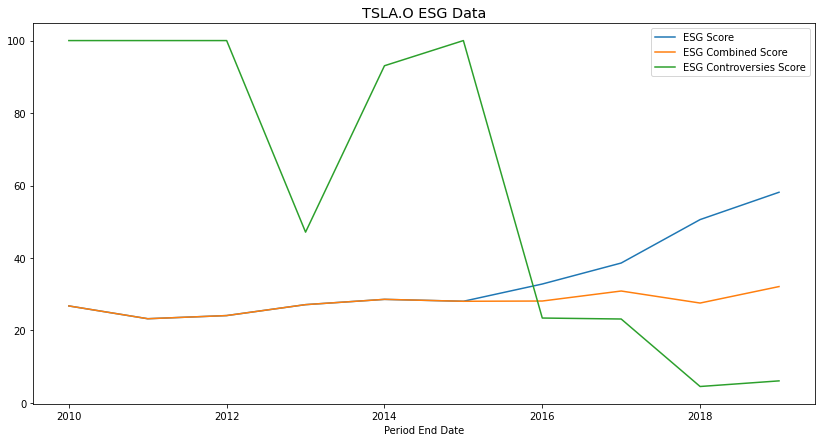

In [14]:
# Plotting a Graph

fig = plt.figure()

plt.ticklabel_format(style = 'plain')
plt.title('%s ESG Data' % (universe), color='black',fontsize='x-large')
ax = fig.gca()

df_plot.plot(kind='line', ax = fig.gca(),x='Period End Date', y=['ESG Score','ESG Combined Score','ESG Controversies Score'],figsize=(14,7) )
plt.show()

## Conclusion

The jupyter/scipy-notebook image provides Jupyter Server with a handful of libraries that is enough for building a financial, data science notebook application. You do not need to set up Anaconda, a virtual environment, and install all dependencies manually anymore.

## <a id="references"></a>References

You can find more details regarding the Refinitiv Data Platform APIs, Jupyter Docker Stacks, and related technologies for this notebook from the following resources:
* [Refinitiv Data Platform APIs page](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) on the [Refinitiv Developer Community](https://developers.refinitiv.com/) website.
* [Refinitiv Data Platform APIs Playground page](https://api.refinitiv.com).
* [Refinitiv Data Platform APIs: Introduction to the Request-Response API](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials#introduction-to-the-request-response-api).
* [Refinitiv Data Platform APIs: Authorization - All about tokens](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/tutorials#authorization-all-about-tokens).
* [Jupyter Dokcer Stacks page](https://jupyter-docker-stacks.readthedocs.io/en/latest/index.html)
* [Jupyter Dokcer Stack on DockerHub](https://hub.docker.com/u/jupyter) website

For any questions related to RRefinitiv Data Platform APIs, please use the following forum on the [the Developers Community Q&A page](https://community.developers.refinitiv.com/).
- [RDP APIs Forum](https://community.developers.refinitiv.com/spaces/231/index.html).